In [1]:
from scope import ScopeSolver
import jax.numpy as jnp
import numpy as np
from sklearn.datasets import make_sparse_spd_matrix
from sklearn.covariance import GraphicalLassoCV, ledoit_wolf
import matplotlib.pyplot as plt

In [2]:
import os

os.environ[
    "CUDA_VISIBLE_DEVICES"
] = ""  # force use CPU because there is an error when using GPU in my environment
# RuntimeError: jaxlib/cusolver_kernels.cc:44: operation cusolverDnCreate(&handle) failed: cuSolver internal error

In [4]:
n, p = 200, 15

np_rdm = np.random.RandomState(0)
pre = make_sparse_spd_matrix(
    p, alpha=0.8, smallest_coef=0.5, largest_coef=1, random_state=np_rdm
)
k = int((np.count_nonzero(pre) - p) / 2)
cov = np.linalg.inv(pre)
d = np.sqrt(np.diag(cov))
cov /= d
cov /= d[:, np.newaxis]
pre *= d
pre *= d[:, np.newaxis]
X = np_rdm.multivariate_normal(np.zeros(p), cov, size=n)
X -= X.mean(axis=0)
emp_cov = np.dot(X.T, X) / n
emp_pre = np.linalg.inv(emp_cov)

In [5]:
def graphical_guassian_objective(params):
    Omega = jnp.zeros((p, p))
    Omega = Omega.at[np.triu_indices(p)].set(params)
    Omega = jnp.where(Omega, Omega, Omega.T)
    return jnp.sum(emp_cov * Omega) - jnp.log(jnp.linalg.det(Omega))

In [19]:
solver = ScopeSolver(
    int(p * (p + 1) / 2),
    k + p,
    always_select=np.where(np.triu_indices(p)[0] == np.triu_indices(p)[1])[0],
    #regular_coef=1.0,
    file_log_level="debug"
)  # always select diagonal elements
solver.solve(graphical_guassian_objective, init_params=pre[np.triu_indices(p)])
params = solver.get_params()
support_set = solver.get_support_set()

est_params = np.zeros((p, p))
est_params[np.triu_indices(p)] = params
est_params = np.where(est_params, est_params, est_params.T)
# print("Estimated parameter:\n", est_params)
# print("True parameter:\n", pre)

In [22]:
graphical_guassian_objective(pre[np.triu_indices(p)])

Array(8.820492, dtype=float32)

In [24]:
graphical_guassian_objective(params)

Array(9.25882, dtype=float32)

In [16]:
np.where(np.triu_indices(p)[0] == np.triu_indices(p)[1])[0]

array([  0,  15,  29,  42,  54,  65,  75,  84,  92,  99, 105, 110, 114,
       117, 119])

In [10]:
def acc(model, true):
    model_coef = set(np.nonzero(model)[0])
    data_coef = set(np.nonzero(true)[0])
    print(len(model_coef & data_coef) / len(data_coef)) 

In [20]:
acc(params, pre[np.triu_indices(p)])

0.8709677419354839


In [12]:
glCV_model = GraphicalLassoCV().fit(X)
glCV_pre = glCV_model.precision_

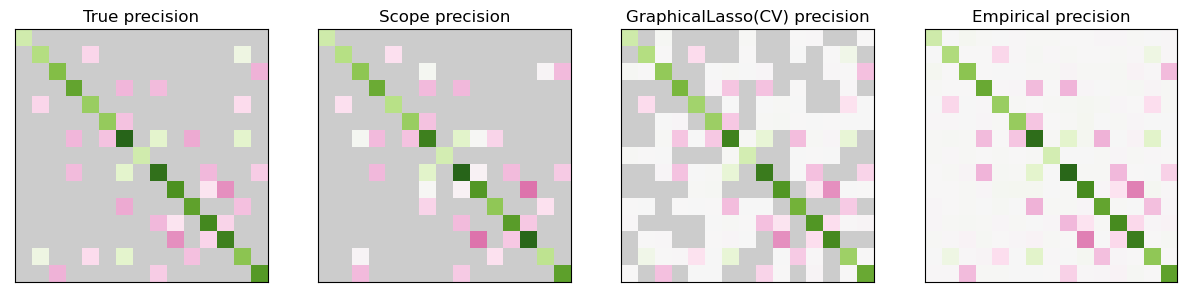

In [21]:
plt.figure(figsize=(15, 5))
plot_of_pre = [
    ("True", pre),
    ("Scope", est_params),
    ("GraphicalLasso(CV)", glCV_pre),
    ("Empirical", emp_pre),
]
vmax = np.abs(pre).max()
for i, (model, its_pre) in enumerate(plot_of_pre):
    ax = plt.subplot(1, 4, i + 1)
    plt.imshow(
        np.ma.masked_equal(its_pre, 0),
        interpolation="nearest",
        vmin=-vmax,
        vmax=vmax,
        cmap=plt.cm.PiYG,
    )
    plt.xticks(())
    plt.yticks(())
    plt.title("%s precision" % model)
    if hasattr(ax, "set_facecolor"):
        ax.set_facecolor(".8")
    else:
        ax.set_axis_bgcolor(".8")